# Random Forest Simulation

In [8]:
import numpy as np
import pandas as pd 
import sys
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Get the ranking Data
rankings = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/fifa_ranking.csv")
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

# Fix some country names
rankings = rankings.replace({"IR Iran": "Iran"})
# Get weighted points by summing cur_year_avg_weighted + two_year_ago_weighted + three_year_ago_weighted
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date']) # change to pandas datetime format

# Get the match Data
matches = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/results.csv")

# Fix some country names
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

# Get the world cup fixture data
world_cup = pd.read_csv("https://raw.githubusercontent.com/rajeevratan84/data-analyst-bootcamp/master/WorldCup2018Dataset.csv")

# extract relavent columns
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

# Drop NAs
world_cup = world_cup.dropna(how='all')

# Fix some country names
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
# set index to team 
world_cup = world_cup.set_index('Team')

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a team ranking dictionary
def get_team_ranking_data(team, date, ranking_data):
    if date is None:
        team_data = ranking_data.loc[ranking_data['country_full'] == team]
    else:
        team_data = ranking_data.loc[(ranking_data['country_full'] == team) & (ranking_data['rank_date'] <= date)]
    
    if len(team_data) > 0:
        team_data = team_data.loc[team_data['rank_date'].idxmax()]
        return {'rank': team_data['rank'], 'weighted_points': team_data['weighted_points']}
    return None

# Prepare the dataset
def get_match_features(match, ranking_data):
    home_team = get_team_ranking_data(match['home_team'], match.get('date', None), ranking_data)
    away_team = get_team_ranking_data(match['away_team'], match.get('date', None), ranking_data)
    
    if home_team is None or away_team is None:
        return None
    
    features = [home_team['rank'], home_team['weighted_points'],
                away_team['rank'], away_team['weighted_points']]
    return features

In [42]:
# Create a dictionary to store team rankings
team_rankings = {}

# Get the latest ranking data for each team
for index, row in rankings.iterrows():
    country = row['country_full']
    if country not in team_rankings or team_rankings[country]['rank_date'] < row['rank_date']:
        team_rankings[country] = {
            'rank': row['rank'],
            'weighted_points': row['weighted_points'],
            'rank_date': row['rank_date']
        }

# Modify get_match_features to use team_rankings
def get_match_features(home_team, away_team, ranking_data):
    home_team_ranking = team_rankings.get(home_team, None)
    away_team_ranking = team_rankings.get(away_team, None)

    if home_team_ranking is None or away_team_ranking is None:
        return None

    return [home_team_ranking['rank'] - away_team_ranking['rank']]


# Get the features and labels for training
X = []
y = []
for index, match in matches.iterrows():
    if match['home_team'] in rankings['country_full'].values and match['away_team'] in rankings['country_full'].values:
        features = get_match_features(match['home_team'], match['away_team'], rankings)
        if features is not None:
            X.append(features)
            y.append(1 if match['home_score'] > match['away_score'] else 0)

print(f"Number of samples: {len(X)}")


Number of samples: 34261


## Measuring the accuracy

In [43]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Test the classifier
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6351962644097475


## Measuring the AUC score

In [44]:
# Import roc_auc_score function
from sklearn.metrics import roc_auc_score

# Fit the RandomForestClassifier model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get the predicted probabilities for the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class (class 1)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC score:", auc_score)

AUC score: 0.6937635987314782


In [55]:
def predict_winner(team1, team2, ranking_data, classifier):
    team1_name = team1[0] if isinstance(team1, tuple) else team1
    team2_name = team2[0] if isinstance(team2, tuple) else team2
    
    features = get_match_features(team1_name, team2_name, ranking_data)
    prediction = classifier.predict([features])
    probabilities = classifier.predict_proba([features])
    winner = team1_name if prediction == 1 else team2_name

    return winner, probabilities[0]


In [56]:
# Predict the group stage winners
world_cup_rankings = rankings.loc[rankings['rank_date'] == rankings['rank_date'].max(), :]
group_winners = []

for group, teams in world_cup.groupby('Group'):
    group_teams = [world_cup_rankings.loc[world_cup_rankings['country_full'] == team, 'country_full'].iloc[0] for team in teams.index]
    winner = group_teams[0]
    
    for i, team1 in enumerate(group_teams):
        for j, team2 in enumerate(group_teams[i+1:]):
            winner = predict_winner(team1, team2, world_cup_rankings, clf)
    
    group_winners.append(winner)


In [60]:
knockout_rounds = ['Round of 16', 'Quarterfinal', 'Semifinal', 'Final']
round_winners = group_winners

for knockout_round in knockout_rounds:
    print(f"{knockout_round} winners:")
    new_round_winners = []

    if len(round_winners) == 1:
        print(f"{knockout_round} winner is {round_winners[0]}")
        break
    
    for i in range(0, len(round_winners), 2):
        team1 = round_winners[i]
        team2 = round_winners[i+1]
        winner, probabilities = predict_winner(team1, team2, world_cup_rankings, clf)
        new_round_winners.append(winner)
        print(f"{team1} vs {team2}: {winner} with probabilities {probabilities}")
            
    round_winners = new_round_winners


Round of 16 winners:
('Uruguay', array([0.72378132, 0.27621868])) vs ('Iran', array([0.60291518, 0.39708482])): Uruguay with probabilities [0.40007225 0.59992775]
('Denmark', array([0.52948649, 0.47051351])) vs ('Croatia', array([0.37355861, 0.62644139])): Denmark with probabilities [0.46579588 0.53420412]
('Costa Rica', array([0.46086247, 0.53913753])) vs ('Sweden', array([0.38448294, 0.61551706])): Sweden with probabilities [0.52948649 0.47051351]
('England', array([0.56067092, 0.43932908])) vs ('Colombia', array([0.37729582, 0.62270418])): England with probabilities [0.460149 0.539851]
Quarterfinal winners:
Uruguay vs Denmark: Denmark with probabilities [0.56388506 0.43611494]
Sweden vs England: England with probabilities [0.52887442 0.47112558]
Semifinal winners:
Denmark vs England: Denmark with probabilities [0.49565336 0.50434664]
Final winners:
Final winner is Denmark


## Generate a plot to visualize this

/var/folders/hm/f_2f7w212174qh26d8_r_npc0000gn/T/ipykernel_4775/3822713051.py:20: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='twopi')


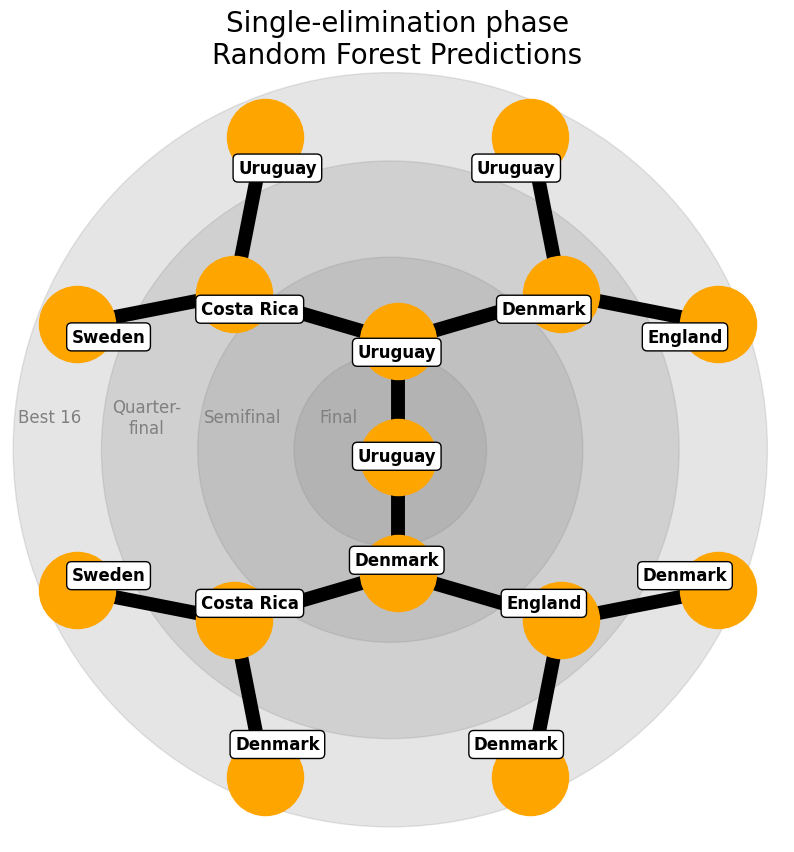

In [68]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import pandas as pd

# Update this with the list of team names in the correct order
team_names = [
    'Uruguay', 'Iran', 
    'Denmark', 'Croatia', 
    'Costa Rica', 'Sweden', 
    'England', 'Colombia',
    'Uruguay', 'Denmark',
    'Sweden', 'England',
    'Denmark', 'England',
    'Denmark'
]

# Create a balanced tree with the same structure as the tournament
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1)

# Add circles
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), cp, color='grey', alpha=0.2)) for cp, c in circle_positions]

# Draw the graph
nx.draw(G, pos,
        node_color='orange',
        node_size=3000,
        alpha=1,
        edge_color='black',
        width=10,
        with_labels=False)

# Create the labels dictionary with integer keys
labels = {i: team for i, team in enumerate(team_names)}

# Set parent node (winner) labels correctly
for i in range(len(labels) // 2):
    labels[2 * i + 1] = labels[2 * i]

# Draw custom node labels
shifted_pos = {k: [(v[0] - centre) * 0.9 + centre, (v[1] - centre) * 0.9 + centre] for k, v in pos.items()}
nx.draw_networkx_labels(G,
                        pos=shifted_pos,
                        labels=labels,
                        font_size=12,
                        font_weight='bold',
                        font_color='black',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1, alpha=1))

# Draw stage labels
texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre + 20, t, fontsize=12, color='grey', va='center', ha='center') for p, t, c in texts]

plt.axis('equal')
plt.title('Single-elimination phase\nRandom Forest Predictions', fontsize=20)
plt.show()
